## Краткое описание проекта:

Стартап занимается продажей продуктов питания. Необходимо разобраться, как ведут себя пользователи его мобильного приложения.

<b>Цели:</b>
 - изучить воронку продаж;
 - исследовать результаты A/A/B эксперимента по замене шрифта;
 
 
 <b>Данные:</b>
 
 Каждая запись в логе — это действие пользователя, или событие.
 - EventName — название события;
 - eviceIDHash — уникальный идентификатор пользовател;
 - EventTimestamp — время события;
 - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st
import warnings

warnings.filterwarnings('ignore')

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
logs.head(2)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


Для удобства переименуем названия столбцов: добавим между словами нижние подчеркивания и приведем все к нижнему регистру.

In [3]:
logs = logs.rename(columns = {
    'EventName': 'event_name',
    'DeviceIDHash':'device_id_hash',
    'EventTimestamp':'event_times_stamp',
    'ExpId':'exp_id'
})
logs.head(2)

,event_name,device_id_hash,event_times_stamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   event_name         244126 non-null  object
 1   device_id_hash     244126 non-null  int64 
 2   event_times_stamp  244126 non-null  int64 
 3   exp_id             244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков нет, но необходимо заменить тип данных в столбце event_times_stamp на время.

In [5]:
logs['event_times_stamp'] = pd.to_datetime(logs['event_times_stamp'], unit='s')
logs['event_times_stamp'].dtype

dtype('<M8[ns]')

Отдельно добавим столбец с датой:

In [6]:
logs['date'] = logs['event_times_stamp'].dt.date
logs.head(2)

,event_name,device_id_hash,event_times_stamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25


Рассмотрим наличие ошибок в event_name

In [7]:
logs['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Названий с ошибками нет. Для дальнейшего удобства также заменим обозначения на более простые: приведем к нижнему регистру, а между словами вставим пробелы.

In [8]:
old_events = logs['event_name'].unique()
clear_events = ['main screen appear', 'payment screen successful', 'cart screen appear', 
                'offers screen appear', 'tutorial']

event_counter = 0
for i in old_events:
    logs.loc[logs['event_name'] == i, 'event_name'] = clear_events[event_counter]
    event_counter += 1
    
logs['event_name'].unique()

array(['main screen appear', 'payment screen successful',
       'cart screen appear', 'offers screen appear', 'tutorial'],
      dtype=object)

Проверим наличие очевидно не корректных данных в столбцах event_time_stamp и  exp_id:

In [9]:
logs['exp_id'].unique()

array([246, 248, 247])

Все значения корректны.

In [10]:
[logs['event_times_stamp'].min(), logs['event_times_stamp'].max()]

[Timestamp('2019-07-25 04:43:36'), Timestamp('2019-08-07 21:15:17')]

Все значения корректны.  

Проверим наличие дубликатов:

In [11]:
sum(logs.duplicated())

413

Обнаружили 413 дубликатов, это ошибочные данные, т.к. действие фиксируются с точностью до секунды и один пользователь не может в одну секунду выполнить одно и то же действие дважды. Поэтому избавимся от дубликатов.

In [12]:
logs = logs.drop_duplicates(ignore_index=True)
sum(logs.duplicated())

0

Сразу проверим наличие пользователей, которые одновременно попадают в несколько групп, и если такие будут, то уберем их:

In [13]:
group_users = logs.groupby('device_id_hash', as_index = False).agg({'exp_id':'nunique'})
group_users = group_users.sort_values(by = 'exp_id', ascending = False)
group_users['exp_id'].max()

1

Пользователей, входящих одновременно в несколько групп, нет.

<b>Вывод: </b> в процессе подготовки
 - заменили тип данных столбца event_times_stamp, 
 - добавили столбец date с датой лога, 
 - привели к нижнему регистру и добавили нижние подчеркивания в названиях столбцов, 
 - удалили дубликаты.

## Изучение и проверка данных

### Количество событий и пользователей в логе

In [14]:
print('Всего событий в логе:', len(logs))
print('Всего пользователей в логе:', logs['device_id_hash'].nunique())

Всего событий в логе: 243713
Всего пользователей в логе: 7551


### Среднее количество событий на пользователя

Чтобы понять лучше использовать срденее или медиану изучим распределение количества событий на пользователя.

Text(0, 0.5, 'Пользователи')

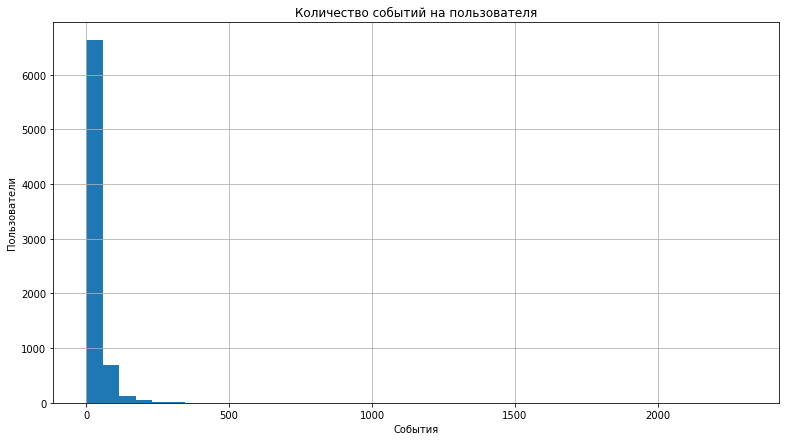

In [15]:
plt.figure(figsize=(13, 7))
plt.title('Количество событий на пользователя')
ax = logs.groupby('device_id_hash', as_index=False).agg({'exp_id':'count'})['exp_id'].hist(bins = 40)
ax.set_xlabel('События')
ax.set_ylabel('Пользователи')

In [16]:
logs.groupby('device_id_hash', as_index=False).agg({'exp_id':'count'})['exp_id'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: exp_id, dtype: float64

Срденее значение значение - 32 события, а медианное - 20, это говорит о наличии небольшого числа пользователей с большим количеством событий, существенно выше среднестатистического. Максимальное значение - 2 307 событий на одного пользователя.

### Период

Исследуем период проведения теста:

In [17]:
print('min:', logs['date'].min(),'\nmax:', logs['date'].max())

min: 2019-07-25 
max: 2019-08-07


In [18]:
print('Продоложительность:', logs['date'].nunique())

Продоложительность: 14


Проверим во все ли дни были одинаково полные данные:

In [19]:
logs.groupby('date', as_index=False).agg({'exp_id':'count'})

,date,exp_id
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


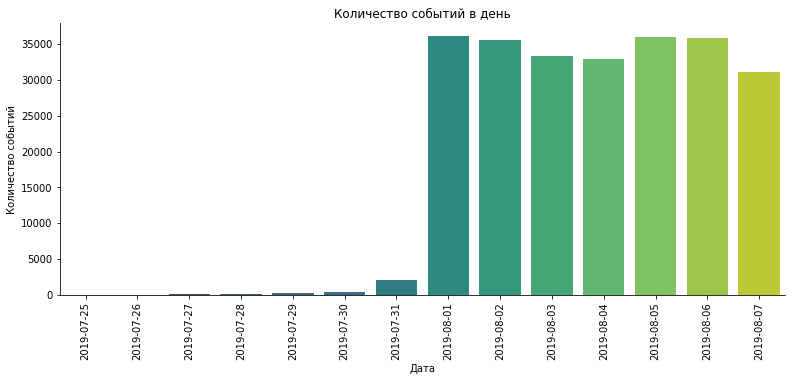

In [20]:
plt.figure(figsize=(13, 5))
plt.title('Количество событий в день')
ax = sns.barplot(
    data = logs.groupby('date', as_index=False).agg({'exp_id':'count'}), 
    x = 'date',
    y = 'exp_id', 
    palette="viridis"
)
ax.set_xlabel('Дата')
ax.set_ylabel('Количество событий')
plt.xticks(rotation = 90)
sns.despine() 

Видим, что количество событий распределено крайне не равномерно: до 1 августа количество событий постепенно нарастает, но не доходит до 2000, а после держится выше 30 000. Чтобы лишние данные не искажали финальный результат, будем учитывать только данные с 1 августа.

In [21]:
logs = logs[logs['date']>=pd.to_datetime('2019-08-01')]
logs.head(2)

,event_name,device_id_hash,event_times_stamp,exp_id,date
2826,tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,main screen appear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01


Проверим сколько пользователей и событий мы потеряли после сокращения периода:

In [22]:
print('Потеряли событий после отбрасывания старых дат:', 243713 - len(logs))
print('Потеряли пользователей:', 7551 - logs['device_id_hash'].nunique())

Потеряли событий после отбрасывания старых дат: 2826
Потеряли пользователей: 17


Также проверим сколько пользователей осталось в каждой из групп:

In [23]:
groups = logs.groupby('exp_id', as_index=False).agg({'device_id_hash': 'nunique'})
groups.columns = ['exp_id', 'user_amount']
groups

,exp_id,user_amount
0,246,2484
1,247,2513
2,248,2537


В каждой из групп осталось около 2 500 участников.

### Выводы:
 - В сырых данных было 243 713 события и 7 551 пользователей.
 - В среднем на человека приходится 20 событий(взяли медианное значение, т.к. есть пользователи с существенно завышенным количеством событий, искажающими среднее значение)
 - До 01 августа данные были не полными, поэтому на самом деле располагаем данными за период с 01 августа по 7 августа.
 - После устранения данных старше 01 августа общее число событий сократилось на 2826, а число пользователей на 17.
 - В каждой из экспериментальных групп около 2500 пользователей.

## Воронка событий

### Распределение событий.

Посмотрим распределение событий по их тиам:

In [24]:
events = logs.groupby('event_name', as_index=False).agg({'exp_id':'count'})\
.sort_values(by = 'exp_id', ascending = False)
events.columns = ['event_name', 'amount']
events

,event_name,amount
1,main screen appear,117328
2,offers screen appear,46333
0,cart screen appear,42303
3,payment screen successful,33918
4,tutorial,1005


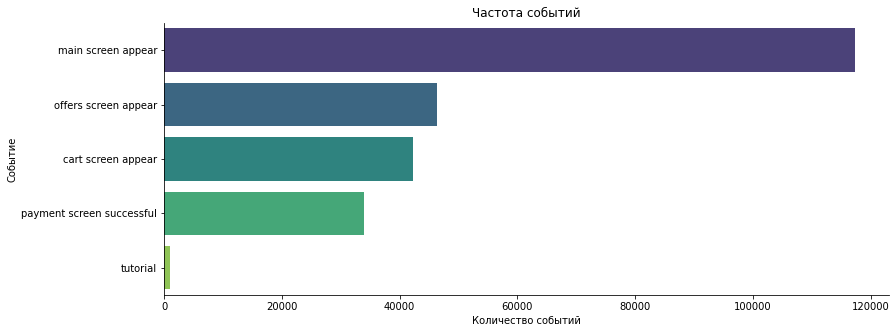

In [25]:
plt.figure(figsize=(13, 5))
plt.title('Частота событий')
ax = sns.barplot(
    data = events, 
    x = 'amount',
    y = 'event_name', 
    palette="viridis"
)
ax.set_xlabel('Количество событий')
ax.set_ylabel('Событие')
sns.despine() 

Около половины всех событий занимает появление главного экрана, потом последовательно идут поялвение экрана предложения, появление экрана корзины и экран успешной оплаты. Меньше всего пользователи изучают инструкци, всего 1005 раз.

### Распределение пользователей по событиям

In [26]:
event_users = logs.groupby('event_name', as_index = False).agg({'device_id_hash':'nunique'})\
.sort_values(by = 'device_id_hash', ascending = False)
event_users.columns = ['event_name', 'user_amount']
event_users['user_share'] = event_users['user_amount']/logs['device_id_hash'].nunique()
event_users.style.format({'user_share':'{:.2%}'})

,event_name,user_amount,user_share
1,main screen appear,7419,98.47%
2,offers screen appear,4593,60.96%
0,cart screen appear,3734,49.56%
3,payment screen successful,3539,46.97%
4,tutorial,840,11.15%


Не все пользователи увидели главный экран, который явлеяется первым этапом воронки, из этого следует отсутсвие необходимости прохождения всех этапов воронки пользователем.

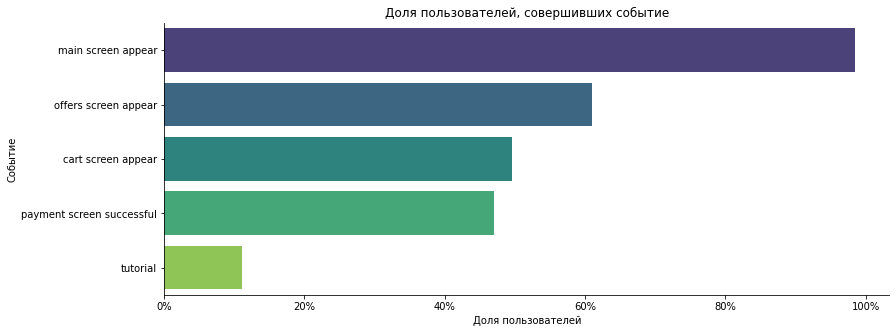

In [27]:
plt.figure(figsize=(13, 5))
plt.title('Доля пользователей, совершивших событие')
ax = sns.barplot(
    data = event_users, 
    x = 'user_share',
    y = 'event_name', 
    palette="viridis"
)
ax.set_xlabel('Доля пользователей')
ax.set_ylabel('Событие')
vals = ax.get_xticks()
ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])
sns.despine()

Главный экран просматривали 98% пользователей, экран с предложением просматривали 61%, зашли в корзину -  50%, удачно оплатили - 47%. Обучение проходили всего 11%.

### Воронка

Вероятнее всего, пользовательлская воронка выглядит так:
1. просмотр главной страниц 
2. Просмотр страницы с предложением
3. Просмотр корзины
4. Успешная оплата.

Очевидно,  что пользователь может до этапа оплаты без прохождения обучения, это также подтверждается и долей пользователей, которые его проходили.

### Относительная и абсолютная воронки

Построим абсолютную воронку, т.е. воронку в которой все доли расчитываются от изначального количества пользователей:

In [28]:
abs_funnel = event_users[event_users['event_name'] != 'tutorial']
abs_funnel.reset_index(drop=True).style.format({'user_share':'{:.2%}'})

,event_name,user_amount,user_share
0,main screen appear,7419,98.47%
1,offers screen appear,4593,60.96%
2,cart screen appear,3734,49.56%
3,payment screen successful,3539,46.97%


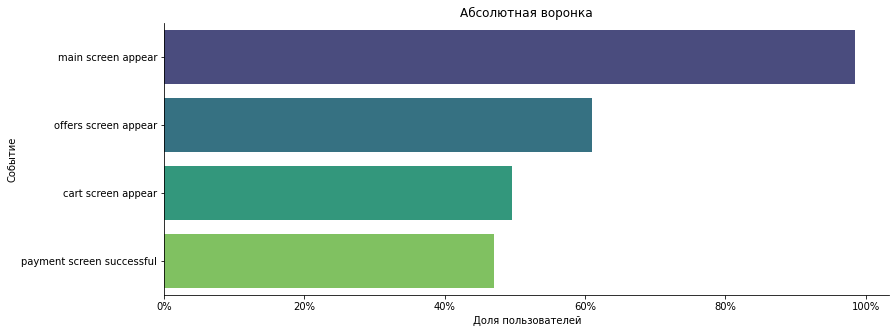

In [29]:
plt.figure(figsize=(13, 5))
plt.title('Абсолютная воронка')
ax = sns.barplot(
    data = abs_funnel, 
    x = 'user_share',
    y = 'event_name', 
    palette="viridis"
)
ax.set_xlabel('Доля пользователей')
ax.set_ylabel('Событие')
vals = ax.get_xticks()
ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])
sns.despine()

Получившаяся воронка воспроизводит диаграму пользователей выше, но без шага tutorial. Тепрь построим относительную воронку:

In [30]:
rel_funnel = abs_funnel
rel_funnel = rel_funnel.reset_index(drop=True)

# Создаем столбец с количеством пользователей соответствующим предыдущему этапу
# К Series с общим числом пользователей добавляем срез из abs_funnel
rel_funnel['prev_amount'] = (pd.Series(logs['device_id_hash'].nunique())
                            .append(abs_funnel.iloc[0:-1, 1]).reset_index(drop=True))

rel_funnel['user_share'] = rel_funnel['user_amount']/rel_funnel['prev_amount']
rel_funnel = rel_funnel.drop('prev_amount', axis = 1)
rel_funnel.style.format({'user_share':'{:.2%}'})

,event_name,user_amount,user_share
0,main screen appear,7419,98.47%
1,offers screen appear,4593,61.91%
2,cart screen appear,3734,81.30%
3,payment screen successful,3539,94.78%


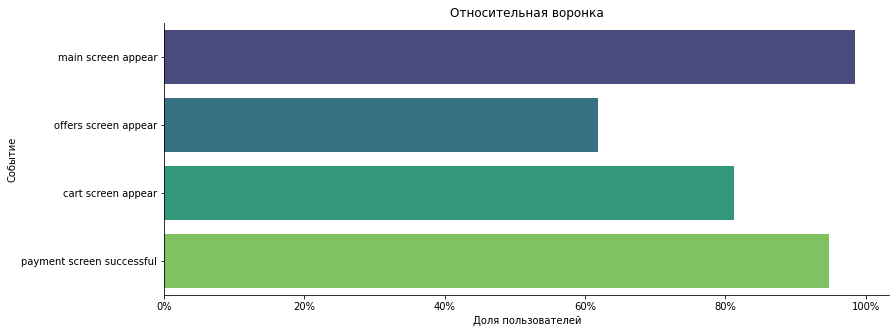

In [31]:
plt.figure(figsize=(13, 5))
plt.title('Относительная воронка')
ax = sns.barplot(
    data = rel_funnel, 
    x = 'user_share',
    y = 'event_name', 
    palette="viridis"
)
ax.set_xlabel('Доля пользователей')
ax.set_ylabel('Событие')
vals = ax.get_xticks()
ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])
sns.despine()

Больше всего пользователей теряется на 2-ом шаге(появлении экрана предложения), всего 62% пользователей, увидевших главный экран доходят до следующего этапа.

По абсолютной воронке видим, что от первого до последнего шагов проходят 46.97% от всех пользователей.

### Выводы:
 - Около половины всех событий занимает появление главного экрана, потом последовательно идут появление экрана предложения, появление экрана корзины и экран успешной оплаты. Меньше всего пользователи изучают инструкци, всего 1005 раз.
 - Предполагаемя воронка событий от посещения сайта до покупки:
    1. просмотр главной страниц 
    2. Просмотр страницы с предложением
    3. Просмотр корзины
    4. Успешная оплата.
 - Около 38% пользователей отпадает при переходе к 2-ому шагу.
 - Этап успешной оплаты проходят 46,97% от всех пользователей.

## Результаты эксперимента

### Группы

In [32]:
groups = logs.groupby('exp_id', as_index=False).agg({'device_id_hash': 'nunique'})
groups.columns = ['exp_id', 'user_amount']
groups

,exp_id,user_amount
0,246,2484
1,247,2513
2,248,2537


В каждой из групп около 2500 человек, поэтому дальнейшее сравнение не будет искажено численностью групп.

### A/A тесты

Оценим разницу количества участников:

In [33]:
print('{:.2%}'.format(abs(groups['user_amount'][0]/groups['user_amount'][1] - 1)))

1.15%


Численность контрольных групп приблизительно расходится на 1,15%, что не критично.

Создадим общую таблицу, в которой будут демонсрироваться доли пользователей совершивших действие в разбивке по группам и событиям:

In [34]:
funnel_steps = ['main screen appear', 'offers screen appear', 'cart screen appear', 'payment screen successful']

#Создаем df, к которому будем в дальнейшем прикреплять данные
funnels_by_groups = pd.DataFrame(
    {
        'steps':funnel_steps
    }
)


# Циклом для каждой из групп создадим df с абсолютным числом пользователей и долей пользователей
# в разбивке по этапам воронки
for group in [246, 247, 248]:
    df = pd.DataFrame(
            {
                'steps' : funnel_steps,
                group : [
                    logs[(logs['exp_id'] == group) & (logs['event_name'] == i)]['device_id_hash']
                    .nunique() for i in funnel_steps
                ]
            }
        )
    df[str(group)+'_share'] = df[group]/groups[groups['exp_id'] == group]['user_amount'][group - 246]
    
    # Добавляем к созданному в начале funnelfs_by_groups
    funnels_by_groups = funnels_by_groups.merge(df, on='steps')
    
funnels_by_groups.style.format(
    {
        '246_share':'{:.2%}',
        '247_share':'{:.2%}',
        '248_share':'{:.2%}'        
    }
)

,steps,246,246_share,247,247_share,248,248_share
0,main screen appear,2450,98.63%,2476,98.53%,2493,98.27%
1,offers screen appear,1542,62.08%,1520,60.49%,1531,60.35%
2,cart screen appear,1266,50.97%,1238,49.26%,1230,48.48%
3,payment screen successful,1200,48.31%,1158,46.08%,1181,46.55%


Детальней рассмотрим разницу между долями контрольных групп:

In [35]:
funnels_by_groups['246_247_diff'] = abs(funnels_by_groups['246_share'] - funnels_by_groups['247_share'])
funnels_by_groups[['steps', '246_247_diff']].style.format({'246_247_diff':'{:.2%}'})

,steps,246_247_diff
0,main screen appear,0.10%
1,offers screen appear,1.59%
2,cart screen appear,1.70%
3,payment screen successful,2.23%


Видим, что при проверке разниц A/A есть шаги, в которых разница существенно выше 1%. Проверим имеет ли эта разница статистическую значимость.

<b>Выбор критерия:</b> Для проверки будем использовать Z-тест, т.к. в расчетах учитывается только единоразовое выполнение действие каждым пользователем, и следовательно мы можем считать события независимыми.

<b>Выбор уровня значимости:</b> общий уровень значимости возьмем 0.1, но сравнение будет множественным, поэтому для каждого отдельного теста необходимо взять поправку. Возьмем поправку Бонферрони: ноебходимо разделить общий уровень значимости на 16(т.к. отдельных тестов будет 16.)

In [36]:
def z_test(group_A, group_B, step, logs, alpha):   
    
    #Рсчет Z-критерия и p-value
    success = [logs[(logs['exp_id'].isin(group_A)) & (logs['event_name'] == step)]['device_id_hash'].nunique(),
              logs[(logs['exp_id'] == group_B) & (logs['event_name'] == step)]['device_id_hash'].nunique()]
    trials = [logs[(logs['exp_id'].isin(group_A))]['device_id_hash'].nunique(),
             logs[(logs['exp_id'] == group_B)]['device_id_hash'].nunique()]

    p_combined = sum(success)/sum(trials)
    p_diff = success[0]/trials[0] - success[1]/trials[1]

    z = p_diff/mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z))) * 2
    
    #Шаг и таблица
    print(step)
    df = pd.DataFrame(
        {
            'step':[step],
            '_'.join(map(str, group_A)): success[0],
            str(group_B): success[1],
            '_'.join(map(str, group_A)) + '_share': success[0]/trials[0],
            str(group_B) + '_share': success[1]/trials[1]
        }
    )
    display(
        df.style.format(
            {
                '_'.join(map(str, group_A)) + '_share' : '{:.2%}',
                str(group_B) + '_share' : '{:.2%}'
            }
        )
    )
    
        #Вывод гипотез
    print('H0: между долями совершивших собыитие', step, 'в группах', 
          '_'.join(map(str, group_A)),'и', str(group_B), 'разницы нет' )
    print('H1: между долями совершивших собыитие', step, 'в группах',
          '_'.join(map(str, group_A)),'и', str(group_B), 'есть значимая разница')
    print('Уровень значимости:', alpha)
    
        #Выводы
    print('p-значение: {:.2f}'.format(p_value))
    if p_value <= alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
        if p_diff > 0:
            print('Доля совершивших событие', step, 'в группе', '_'.join(map(str, group_A)), 'выше')
        else:
            print('Доля совершивших событие', step, 'в группе', group_B, 'выше')
    else:
        print('Мы не можем отвергнуть нулевую гипотезу')
    print()
    return p_value

In [37]:
for step in funnel_steps:
    z_test([246], 247, step, logs, 0.1/16)

main screen appear


,step,246,247,246_share,247_share
0,main screen appear,2450,2476,98.63%,98.53%


H0: между долями совершивших собыитие main screen appear в группах 246 и 247 разницы нет
H1: между долями совершивших собыитие main screen appear в группах 246 и 247 есть значимая разница
Уровень значимости: 0.00625
p-значение: 0.76
Мы не можем отвергнуть нулевую гипотезу

offers screen appear


,step,246,247,246_share,247_share
0,offers screen appear,1542,1520,62.08%,60.49%


H0: между долями совершивших собыитие offers screen appear в группах 246 и 247 разницы нет
H1: между долями совершивших собыитие offers screen appear в группах 246 и 247 есть значимая разница
Уровень значимости: 0.00625
p-значение: 0.25
Мы не можем отвергнуть нулевую гипотезу

cart screen appear


,step,246,247,246_share,247_share
0,cart screen appear,1266,1238,50.97%,49.26%


H0: между долями совершивших собыитие cart screen appear в группах 246 и 247 разницы нет
H1: между долями совершивших собыитие cart screen appear в группах 246 и 247 есть значимая разница
Уровень значимости: 0.00625
p-значение: 0.23
Мы не можем отвергнуть нулевую гипотезу

payment screen successful


,step,246,247,246_share,247_share
0,payment screen successful,1200,1158,48.31%,46.08%


H0: между долями совершивших собыитие payment screen successful в группах 246 и 247 разницы нет
H1: между долями совершивших собыитие payment screen successful в группах 246 и 247 есть значимая разница
Уровень значимости: 0.00625
p-значение: 0.11
Мы не можем отвергнуть нулевую гипотезу



Ни в одном из событий значимых различий в доле совершивших их между группам 246 и 247 нет, что говорит в пользу корректности собранных данных.

<b>Вывод:</b> 
 - Численность групп различается не существенно;
 - Расхождение долей на разных шагах доходит до 2,23%, что может быть существенным, но тест показывает отстуствие статистически значимого расхождения на всех шагах.

Исходя из этих выводов, будем считать, что данные собраны корректно.

### A1/B тесты

In [38]:
for step in funnel_steps:
    z_test([246], 248, step, logs, 0.1/16)

main screen appear


,step,246,248,246_share,248_share
0,main screen appear,2450,2493,98.63%,98.27%


H0: между долями совершивших собыитие main screen appear в группах 246 и 248 разницы нет
H1: между долями совершивших собыитие main screen appear в группах 246 и 248 есть значимая разница
Уровень значимости: 0.00625
p-значение: 0.29
Мы не можем отвергнуть нулевую гипотезу

offers screen appear


,step,246,248,246_share,248_share
0,offers screen appear,1542,1531,62.08%,60.35%


H0: между долями совершивших собыитие offers screen appear в группах 246 и 248 разницы нет
H1: между долями совершивших собыитие offers screen appear в группах 246 и 248 есть значимая разница
Уровень значимости: 0.00625
p-значение: 0.21
Мы не можем отвергнуть нулевую гипотезу

cart screen appear


,step,246,248,246_share,248_share
0,cart screen appear,1266,1230,50.97%,48.48%


H0: между долями совершивших собыитие cart screen appear в группах 246 и 248 разницы нет
H1: между долями совершивших собыитие cart screen appear в группах 246 и 248 есть значимая разница
Уровень значимости: 0.00625
p-значение: 0.08
Мы не можем отвергнуть нулевую гипотезу

payment screen successful


,step,246,248,246_share,248_share
0,payment screen successful,1200,1181,48.31%,46.55%


H0: между долями совершивших собыитие payment screen successful в группах 246 и 248 разницы нет
H1: между долями совершивших собыитие payment screen successful в группах 246 и 248 есть значимая разница
Уровень значимости: 0.00625
p-значение: 0.21
Мы не можем отвергнуть нулевую гипотезу



При сравнении 246 и 248 групп ни на одном из шагов не было найдено значимой разницы. 

### A2/B тесты

In [39]:
for step in funnel_steps:
    z_test([247], 248, step, logs, 0.05)

main screen appear


,step,247,248,247_share,248_share
0,main screen appear,2476,2493,98.53%,98.27%


H0: между долями совершивших собыитие main screen appear в группах 247 и 248 разницы нет
H1: между долями совершивших собыитие main screen appear в группах 247 и 248 есть значимая разница
Уровень значимости: 0.05
p-значение: 0.46
Мы не можем отвергнуть нулевую гипотезу

offers screen appear


,step,247,248,247_share,248_share
0,offers screen appear,1520,1531,60.49%,60.35%


H0: между долями совершивших собыитие offers screen appear в группах 247 и 248 разницы нет
H1: между долями совершивших собыитие offers screen appear в группах 247 и 248 есть значимая разница
Уровень значимости: 0.05
p-значение: 0.92
Мы не можем отвергнуть нулевую гипотезу

cart screen appear


,step,247,248,247_share,248_share
0,cart screen appear,1238,1230,49.26%,48.48%


H0: между долями совершивших собыитие cart screen appear в группах 247 и 248 разницы нет
H1: между долями совершивших собыитие cart screen appear в группах 247 и 248 есть значимая разница
Уровень значимости: 0.05
p-значение: 0.58
Мы не можем отвергнуть нулевую гипотезу

payment screen successful


,step,247,248,247_share,248_share
0,payment screen successful,1158,1181,46.08%,46.55%


H0: между долями совершивших собыитие payment screen successful в группах 247 и 248 разницы нет
H1: между долями совершивших собыитие payment screen successful в группах 247 и 248 есть значимая разница
Уровень значимости: 0.05
p-значение: 0.74
Мы не можем отвергнуть нулевую гипотезу



При сравнении 247 и 248 групп ни на одном из шагов не было найдено значимой разницы.

### A1+A2/B тесты

In [40]:
for step in funnel_steps:
    z_test([246, 247], 248, step, logs, 0.05)

main screen appear


,step,246_247,248,246_247_share,248_share
0,main screen appear,4926,2493,98.58%,98.27%


H0: между долями совершивших собыитие main screen appear в группах 246_247 и 248 разницы нет
H1: между долями совершивших собыитие main screen appear в группах 246_247 и 248 есть значимая разница
Уровень значимости: 0.05
p-значение: 0.29
Мы не можем отвергнуть нулевую гипотезу

offers screen appear


,step,246_247,248,246_247_share,248_share
0,offers screen appear,3062,1531,61.28%,60.35%


H0: между долями совершивших собыитие offers screen appear в группах 246_247 и 248 разницы нет
H1: между долями совершивших собыитие offers screen appear в группах 246_247 и 248 есть значимая разница
Уровень значимости: 0.05
p-значение: 0.43
Мы не можем отвергнуть нулевую гипотезу

cart screen appear


,step,246_247,248,246_247_share,248_share
0,cart screen appear,2504,1230,50.11%,48.48%


H0: между долями совершивших собыитие cart screen appear в группах 246_247 и 248 разницы нет
H1: между долями совершивших собыитие cart screen appear в группах 246_247 и 248 есть значимая разница
Уровень значимости: 0.05
p-значение: 0.18
Мы не можем отвергнуть нулевую гипотезу

payment screen successful


,step,246_247,248,246_247_share,248_share
0,payment screen successful,2358,1181,47.19%,46.55%


H0: между долями совершивших собыитие payment screen successful в группах 246_247 и 248 разницы нет
H1: между долями совершивших собыитие payment screen successful в группах 246_247 и 248 есть значимая разница
Уровень значимости: 0.05
p-значение: 0.60
Мы не можем отвергнуть нулевую гипотезу



При сравнении обединенной(246 + 247) и 248 групп ни на одном из шагов не было найдено значимой разницы.

### Выводы:
 - Между долями пользователей, совершивших каждый из шагов воронки, контрольных групп статистически значимой разницы нет, количество участников групп также различается не существенно(на 1,15%). При этом, на некоторых этапах воронки разница доходит до 2%. На основании этого допустили, что данные собраны корректно.
 - Значимой разницы между результатами контрольных и экспериментальной групп ни на одном из шагов воронки нет. Из этого следует, что обновление шрифта не меняет поведения пользователей в  приложении.

## Выводы:

 - В данных были дубликаты, которых теоретически не должно было быть, т.к. пользователь не может в одну секунду совершить действие дважды. Поэтому на этапе предобработки их убрали.
 - Изначально были предоставлены данные за двухнедельный период, но в первую неделю данные собирались не в полном объеме, поэтому для анализа использовали только данные второй недели(с 1-го по 7-ое августа).
 - Около половины всех событий занимает появление главного экрана, потом последовательно идут появление экрана предложения, появление экрана корзины и экран успешной оплаты. Меньше всего пользователи изучают инструкци, всего 1005 раз.
 - Для анализа выделили следующу конверсионную воронку, распределение пользователей, совершивших эти действия, подтверждает такой порядок:
    1. просмотр главной страниц 
    2. Просмотр страницы с предложением
    3. Просмотр корзины
    4. Успешная оплата.
 - Больше всего пользователей отсеивается на втором шаге(около 38% от совершивших первое дейстие).
 - До шага оплуспешной оплаты проходит 46,97% от всех пользователей.
 - Данные собрались корректно: значимой разницы между долями контрольных групп нет, существенного расхождения в численности груп тоже нет, но разница между долями доходит до 2%.
 - Значимой разницы между результатами контрольных и тестовой групп нет, обновление шрифта не меняет поведение пользователей в приложении.